Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.7244258872651357

Classification Report:
               precision    recall  f1-score   support

         0.0       0.43      0.14      0.21        21
         1.0       0.57      0.50      0.53        54
         2.0       0.52      0.67      0.58        78
         3.0       0.53      0.46      0.49        83
         4.0       0.90      0.93      0.92       243

    accuracy                           0.72       479
   macro avg       0.59      0.54      0.55       479
weighted avg       0.71      0.72      0.71       479



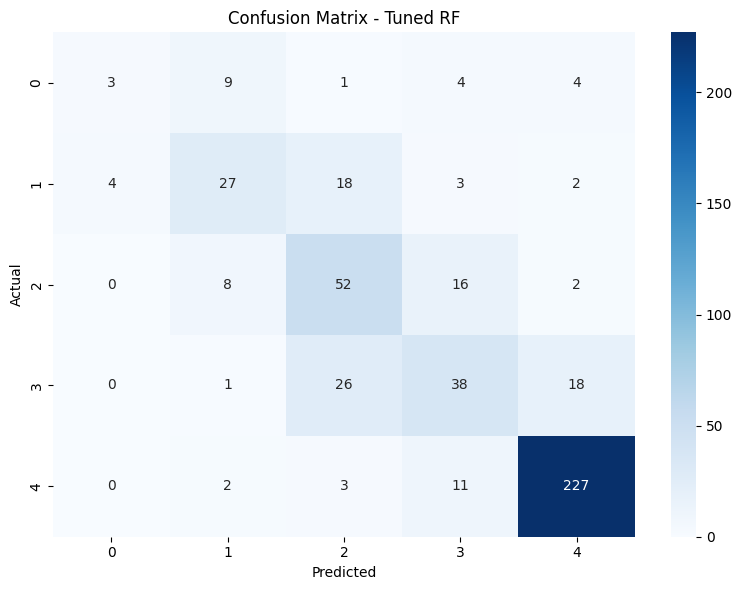

First 20 Predictions:

 First 20 Predictions:
 Actual  Predicted  Match
    4.0        4.0   True
    4.0        4.0   True
    4.0        4.0   True
    4.0        4.0   True
    2.0        1.0  False
    3.0        3.0   True
    2.0        2.0   True
    4.0        4.0   True
    4.0        4.0   True
    3.0        4.0  False
    2.0        2.0   True
    4.0        4.0   True
    4.0        4.0   True
    3.0        3.0   True
    4.0        4.0   True
    4.0        4.0   True
    0.0        4.0  False
    4.0        4.0   True
    3.0        2.0  False
    4.0        4.0   True


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV

#Step 1: Import CSVs
df_train = pd.read_csv('../data/train_data.csv', delimiter=",")
df_test = pd.read_csv('../data/test_data.csv', delimiter=",")

#Step 2: Separate features and target
X_train = df_train.drop(columns=["StudentID", "GradeClass", "GPA"])
y_train = df_train['GradeClass']

X_test = df_test.drop(columns=["StudentID", "GradeClass", "GPA"])
y_test = df_test['GradeClass']

# Step 3: Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 14, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=47),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Step 4: Picking best model from tuning
best_rf = grid_search.best_estimator_
tuned_preds = best_rf.predict(X_test)

# Step 5: Evaluation
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, tuned_preds))
print("\nClassification Report:\n", classification_report(y_test, tuned_preds))

#Confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, tuned_preds), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Tuned RF')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

#Step 6: Save the model as pkl file in artifacts
with open("../artifacts/randomforest_model.pkl", "wb") as file:
    pickle.dump(best_rf, file)

#Step 7: Save predictions to CSV
comparison_df = X_test.copy()
comparison_df["Actual_GradeClass"] = y_test.values
comparison_df["Predicted_GradeClass"] = tuned_preds

#Step 8: Show and save the prediction table

try:
    from IPython.display import display

    # Prepare DataFrame for display
    comparison_df = pd.DataFrame({"Actual": y_test.values,"Predicted": tuned_preds})
    comparison_df["Match"] = comparison_df["Actual"] == comparison_df["Predicted"]

    def highlight_false_text(row):
        styles = []
        for col in row.index:
            if col == "Match" and row["Match"] == False:
                styles.append("color: red; background-color: black")
            else:
                styles.append("background-color: black; color: white")
        return styles

    print("First 20 Predictions:")
    display(comparison_df.head(20).style.apply(highlight_false_text, axis=1))

except Exception as e:
    print("\n First 20 Predictions:")
    print(comparison_df.head(20).to_string(index=False))

comparison_df.to_csv("../artifacts/randomforest_prediction.csv", index=False)